In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

## Create monthly composites from S1, S2 and LS8

In [2]:
from pathlib import Path
import xarray as xr
# Define dataset file paths
DATA_DIR = Path('output/')
DATASETS = {
    'l8': DATA_DIR / 'l8_wofs.nc',
    's1': DATA_DIR / 's1_water.nc',
}

datasets = {name: xr.open_dataset(path).sortby('time') for name, path in DATASETS.items()}

datasets['s2'] = xr.concat([xr.open_dataset(DATA_DIR / 'wofs_s2ab_cloudless_2016.nc'),
                            xr.open_dataset(DATA_DIR / 'wofs_s2ab_cloudless_2017.nc'),
                            xr.open_dataset(DATA_DIR / 'wofs_s2ab_cloudless_2018.nc')], dim='time')

print('Loaded datasets: {}'.format(', '.join(datasets.keys())))

Loaded datasets: l8, s1, s2


Each xarray contains a variable called `wofs` that houses water classifications from the classifiers. Values in these xarray assume one of three values. `1`,`0` for water and not-water as well as `nan` values for areas occluded by cloud or are missing data.  

In [3]:
for key in datasets.keys():
    datasets[key] = datasets[key].isel(time=(datasets[key].wofs.isnull().groupby('time').mean()<0.9).values)

# Subset of coincident (within a day) observations

## Landsat 8 vs Sentinel-2

In [4]:
import pandas as pd

matched_times=pd.merge_asof(datasets['l8'].time.to_dataframe(), datasets['s2'].time.to_dataframe(), 
                            left_index=True, right_index=True, 
                            tolerance=pd.Timedelta('1d'), direction='nearest').dropna(how='any')

In [5]:
ls8_s2=datasets['l8'].sel(time=matched_times['time_x'].values).wofs-datasets['s2'].sel(time=matched_times['time_y'].values).wofs.values

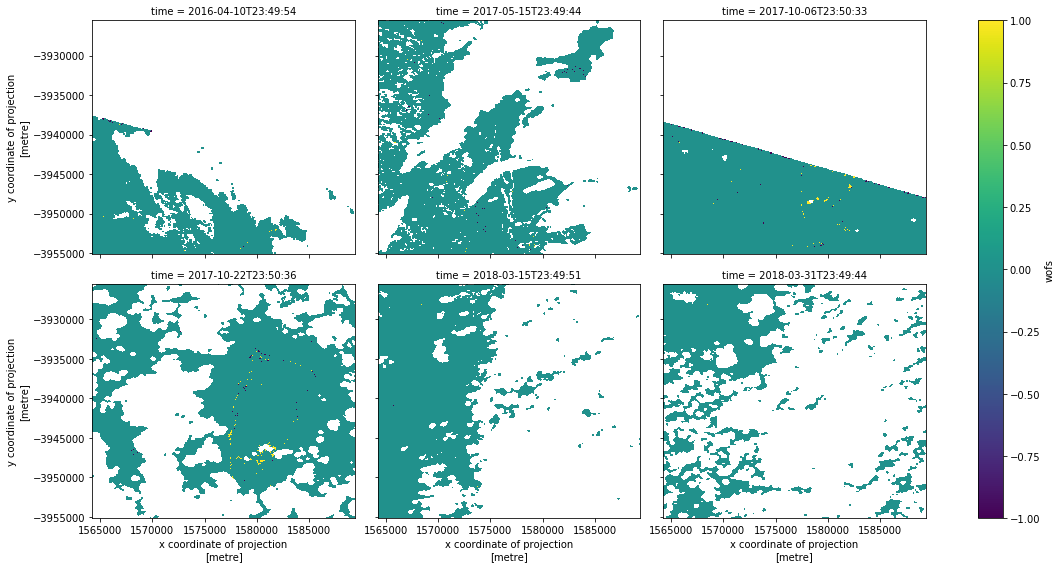

In [6]:
ls8_s2.plot(col='time',col_wrap=3,figsize=(16,8), cmap='viridis')

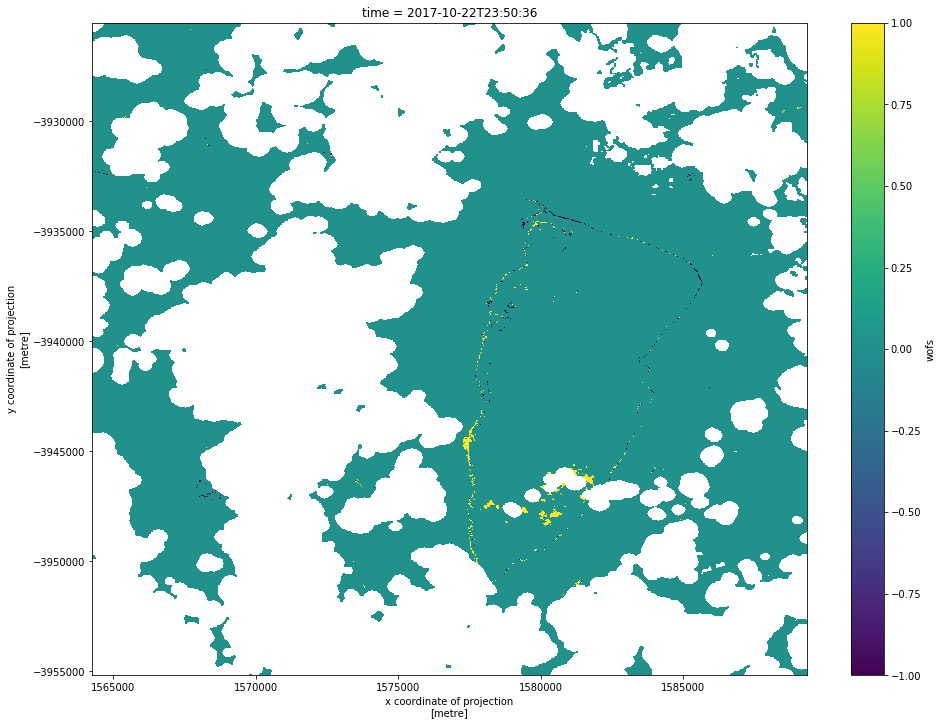

In [7]:
ls8_s2.isel(time=3).plot(figsize=(16,12), cmap='viridis')

## Sentinel-2 and Sentinel-1

In [8]:
matched_times_s2_s1=pd.merge_asof(datasets['s2'].time.to_dataframe(), datasets['s1'].time.to_dataframe(), 
                            left_index=True, right_index=True, 
                            tolerance=pd.Timedelta('1d'), direction='nearest').dropna(how='any')

In [9]:
s2_s1=datasets['s2'].sel(time=matched_times_s2_s1['time_x'].values).wofs-datasets['s1'].sel(time=matched_times_s2_s1['time_y'].values).wofs.values[:,:,::-1]

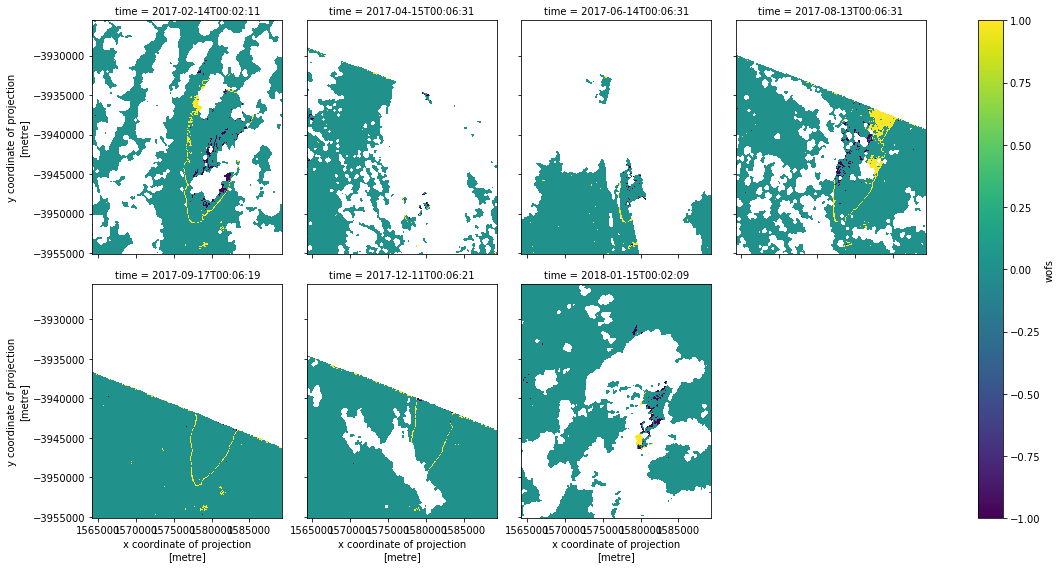

In [10]:
s2_s1.plot(col='time', col_wrap=4, figsize=(16,8), cmap='viridis')

/g/data/v10/public/modules/dea-env/20181015/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


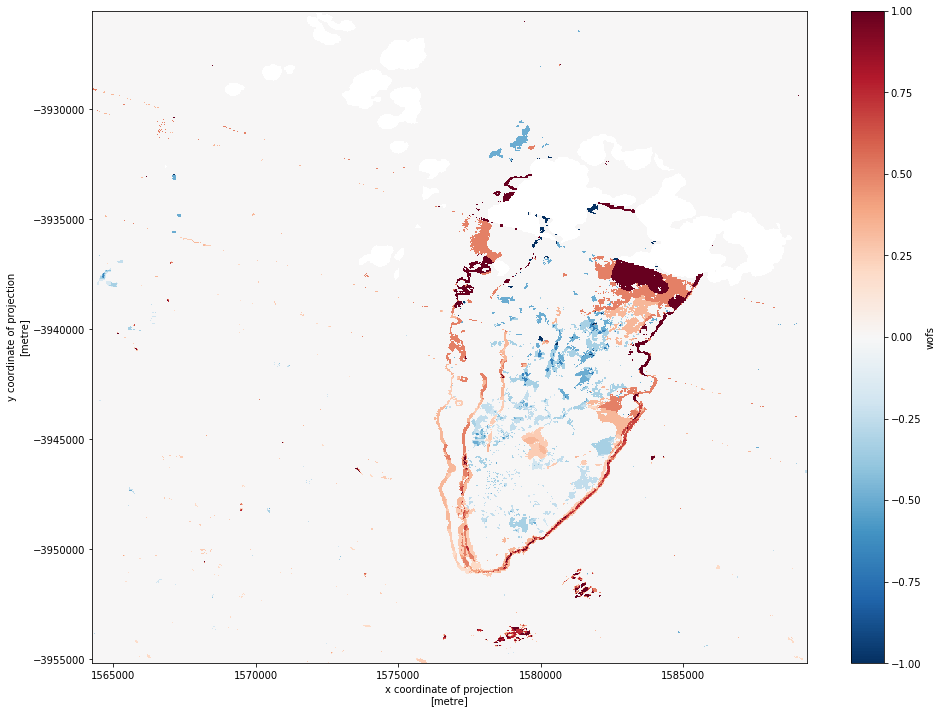

In [11]:
s2_s1.mean(dim='time',skipna=True).plot(figsize=(16,12))

# Landsat vs Sentinel-1

In [12]:
matched_times_l8_s1=pd.merge_asof(datasets['l8'].time.to_dataframe(), datasets['s1'].time.to_dataframe(), 
                            left_index=True, right_index=True, 
                            tolerance=pd.Timedelta('1d'), direction='nearest').dropna(how='any')

In [13]:
l8_s1=datasets['l8'].sel(time=matched_times_l8_s1['time_x'].values).wofs-datasets['s1'].sel(time=matched_times_l8_s1['time_y'].values).wofs.values[:,:,::-1]

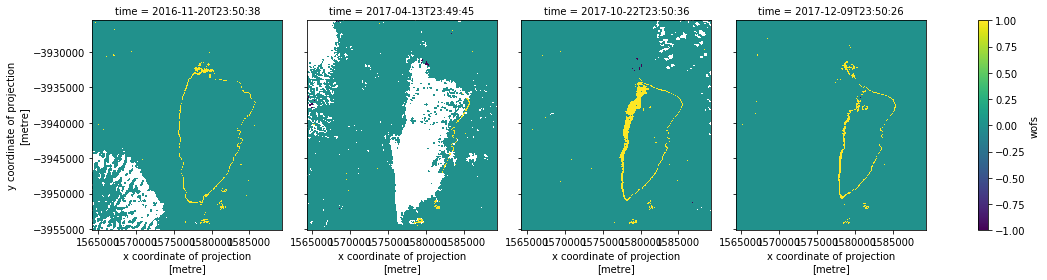

In [14]:
l8_s1.plot(col='time',col_wrap=4,figsize=(16,4), cmap='viridis')

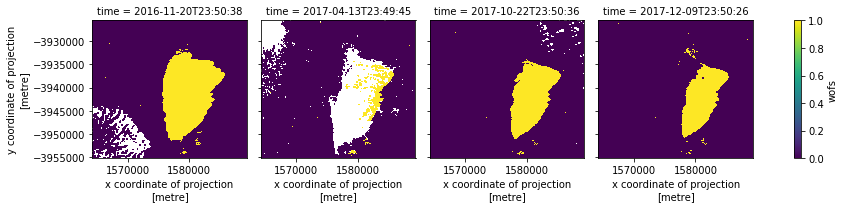

In [15]:
datasets['l8'].sel(time=matched_times_l8_s1['time_x'].values).wofs.plot(col='time', col_wrap=4)

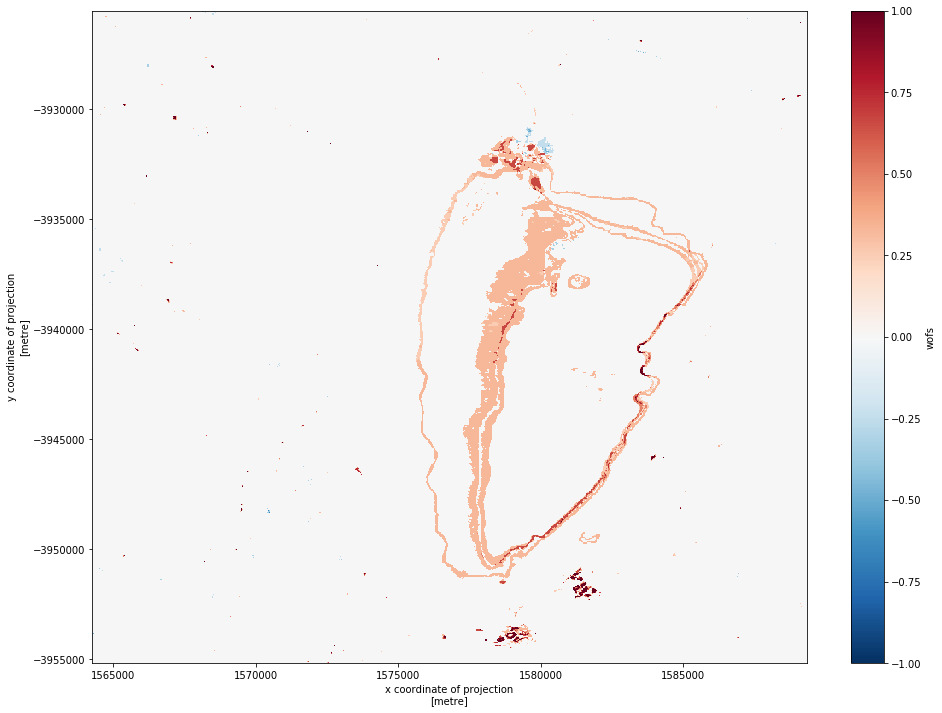

In [16]:
l8_s1.mean(dim='time',skipna=True).plot(figsize=(16,12))